In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [84]:
from sklearn.datasets import fetch_openml
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone, BaseEstimator
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,\
precision_recall_curve, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [3]:
mnist = fetch_openml('mnist_784', version=1)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist['data'], mnist['target']

In [6]:
X.shape

(70000, 784)

In [7]:
y.shape

(70000,)

In [8]:
y[:1]

0    5
Name: class, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [9]:
some_digit = X[:1].values
some_digit_image = some_digit.reshape(28, 28)
some_target = y[0]

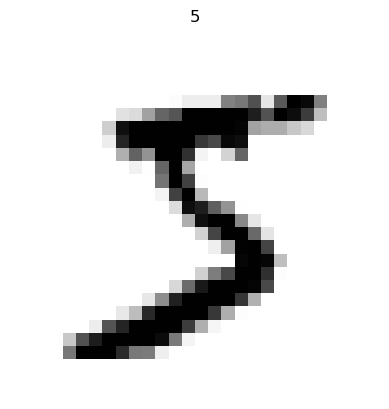

In [10]:
plt.imshow(some_digit_image, cmap = mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.title(some_target)
plt.show()

In [11]:
y = y.astype(np.uint8)

In [12]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classifier
5 and not-5 classifier

In [13]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

### SGD classifier

In [14]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict(some_digit)

array([ True])

# Perfromance Measures

### Measuring Accuracy using Cross-Validation

##### KFold 

In [16]:
skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [17]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


##### Cross-val function

In [18]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

#### dumb classifier

In [19]:
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### Confusion Matrix

In [21]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### Precision and Recall

In [23]:
print(3530/ (3530 + 687))
precision_score(y_train_5, y_train_pred) 

0.8370879772350012


0.8370879772350012

In [24]:
print(3530 / (3530 + 1891))
recall_score(y_train_5, y_train_pred)

0.6511713705958311


0.6511713705958311

In [25]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

#### Precision/Recall Tradeoff

In [26]:
y_scores = sgd_clf.decision_function(some_digit)
y_scores

array([2164.22030239])

In [27]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [28]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [29]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [51]:
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [30]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

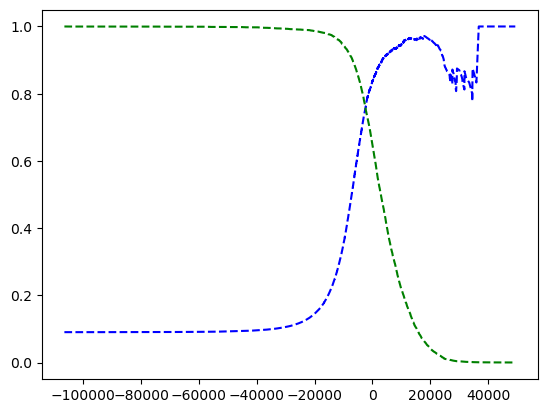

In [31]:
def plot_precision_recall_vs_threshold(precisions, recalls, threholds):
    plt.plot(threholds, precisions[:-1], 'b--', label="Precision")
    plt.plot(threholds, recalls[:-1], 'g--', label="Recall")
#     plt.plot(5000, 0.4, 'r.')
#     plt.vlines(x=5000, ymin=0, ymax=0.9, color='red', ls=':')
#     plt.hlines(y=0.4, xmin=np.min(thresholds), xmax=5000, color='red', ls=':')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [32]:
thresh_90_precision = thresholds[np.argmax(precisions >= 0.9)]
thresh_90_precision

3370.019499143957

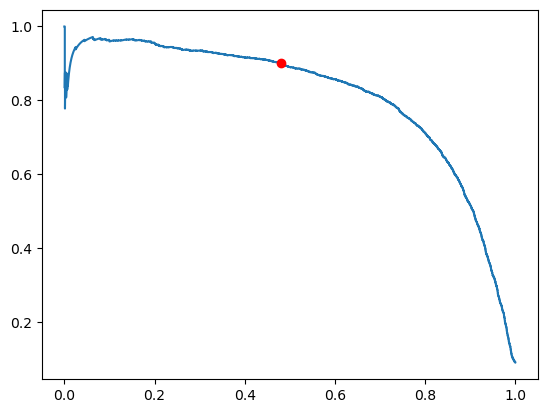

In [33]:
plt.plot(recalls, precisions)
plt.plot(recalls[np.argmax(thresholds == thresh_90_precision)], 
         precisions[np.argmax(thresholds == thresh_90_precision)], 'ro')
plt.show()

In [34]:
y_train_pred_90 = (y_scores >= thresh_90_precision)

In [35]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [36]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### The ROC Curve

In [37]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

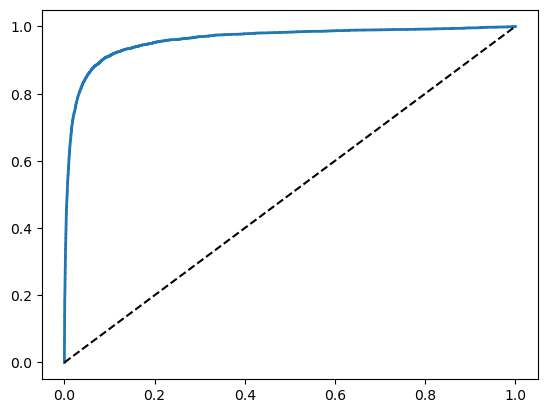

In [38]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    
plot_roc_curve(fpr, tpr)
plt.show()

##### Area Under the Curve (ROC AUC)

In [41]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [43]:
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3, method="predict_proba")

In [47]:
y_probas_forest

array([[0.  , 0.02, 0.02, ..., 0.  , 0.01, 0.01],
       [0.99, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.02, ..., 0.06, 0.02, 0.07],
       ...,
       [0.  , 0.  , 0.  , ..., 0.01, 0.01, 0.05],
       [0.03, 0.02, 0.04, ..., 0.  , 0.01, 0.  ],
       [0.02, 0.01, 0.04, ..., 0.04, 0.72, 0.06]])

In [55]:
y_scores_forest = y_probas_forest[:, 1]
y_scores_forest

array([0.02, 0.  , 0.  , ..., 0.  , 0.02, 0.01])

In [56]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

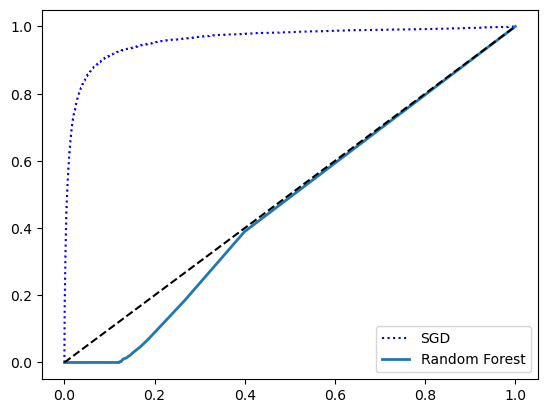

In [57]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [58]:
roc_auc_score(y_train_5, y_scores_forest)

0.46754636002160643

# Multiclass Classification

**1. Strategy:** *One-versus-all (OvA)* \
**2. Stragety:** *One-versus-one (OvO)*

In [59]:
sgd_clf.fit(X_train, y_train) # using OvA
sgd_clf.predict(some_digit)

array([3], dtype=uint8)

In [60]:
some_digit_scores = sgd_clf.decision_function(some_digit)
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [61]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [63]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict(some_digit)

array([5], dtype=uint8)

In [64]:
len(ovo_clf.estimators_)

45

In [65]:
forest_clf.fit(X_train, y_train) # No need for OvA or OvO
forest_clf.predict(some_digit)

array([5], dtype=uint8)

In [66]:
forest_clf.predict_proba(some_digit)

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

In [67]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

In [69]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [70]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)

In [71]:
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

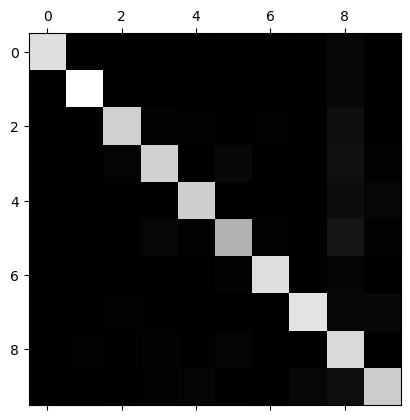

In [72]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [73]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

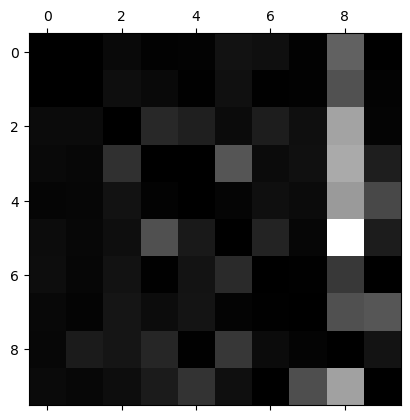

In [74]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [78]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [82]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

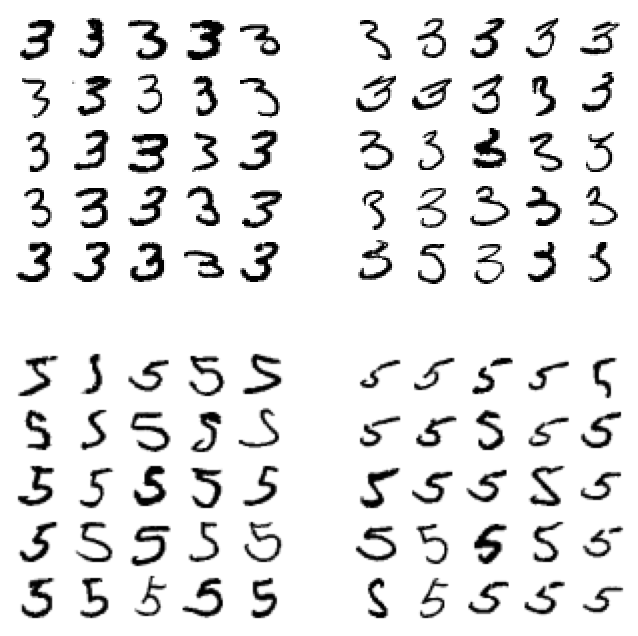

In [83]:
plt.figure(figsize=(8, 8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)

# Multilabel Classification

In [85]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [86]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [87]:
knn_clf.predict(some_digit)

array([[False,  True]])

In [88]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

# Multioutput Classification

In [89]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [97]:
some_index = np.random.randint(len(X_test_mod))

In [98]:
some_index

656

In [93]:
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

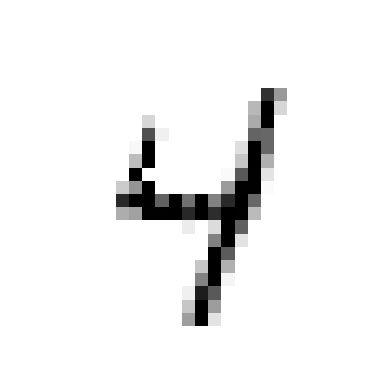

In [102]:
some_index = np.random.randint(len(X_test_mod))
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index].values])
plot_digits(clean_digit)